## XModalix Port First Milestone: ImageVAE + Loader


### Outcome
- Have a image loader and image VAE
- Train this in a notebook
    - With c. elegans and MNIST images


### Checks
- Check loss curves
- Check image recons
- 


### Steps
- Prepare datasets
    - Maybe already done in 00 notebook
- Prepare config
- Write ImageDataset Class
- Write / port ImageVAE

#### IMPORTS

In [1]:
import os
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


#### GLOBALS


In [23]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
        checkpoint_interval=1,
        epochs=50,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "RNA2": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    )
)

In [24]:
xmodalix = acx.XModalix(config=img_config)
ds = xmodalix.preprocess()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='STANDARD' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to'
Checking data type: RNA
Checking data type: RNA2
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'RNA': 260, 'RNA2': 260}, 'annotation': {'paired': 260}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
key: train, type: <class 'dict'

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


In [25]:
xmodalix.fit()

called init loaders
setup fabric
--- Epoch 1/50 ---
torch.Size([51, 10])
torch.Size([51, 10])
torch.Size([49, 1, 64, 64])
torch.Size([53, 10])
torch.Size([53, 10])
torch.Size([53, 1, 64, 64])
torch.Size([57, 10])
torch.Size([57, 10])
torch.Size([49, 1, 64, 64])
torch.Size([51, 10])
torch.Size([51, 10])
torch.Size([49, 1, 64, 64])
torch.Size([53, 10])
torch.Size([53, 10])
torch.Size([46, 1, 64, 64])
torch.Size([54, 10])
torch.Size([54, 10])
torch.Size([45, 1, 64, 64])
torch.Size([54, 10])
torch.Size([54, 10])
torch.Size([48, 1, 64, 64])
torch.Size([56, 10])
torch.Size([56, 10])
torch.Size([50, 1, 64, 64])
torch.Size([42, 10])
torch.Size([42, 10])
torch.Size([39, 1, 64, 64])
Epoch 1/50 - Train Loss: 0.1940
Storing checkpoint for epoch 0...
--- Epoch 2/50 ---
torch.Size([51, 10])
torch.Size([51, 10])
torch.Size([43, 1, 64, 64])
torch.Size([50, 10])
torch.Size([50, 10])
torch.Size([47, 1, 64, 64])
torch.Size([51, 10])
torch.Size([51, 10])
torch.Size([48, 1, 64, 64])
torch.Size([52, 10])
to

In [27]:
result = xmodalix.result

In [22]:
img_config.epochs

3

In [35]:
result.sub_losses.keys()

dict_keys(['total_loss', 'adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss'])

In [48]:
extra = {"extra": 124.}
sub_losses.update(extra)

In [49]:
sub_losses

{'multi_bulk.RNA.recon_loss': 0.6800152659416199,
 'multi_bulk.RNA.var_loss': 0.1442304253578186,
 'multi_bulk.RNA.anneal_factor': 0.9999322891235352,
 'multi_bulk.RNA.effective_beta_factor': 0.09999322891235352,
 'multi_bulk.RNA.loss': 0.6944373250007629,
 'multi_bulk.RNA2.recon_loss': 0.6358762979507446,
 'multi_bulk.RNA2.var_loss': 0.1521577388048172,
 'multi_bulk.RNA2.anneal_factor': 0.9999322891235352,
 'multi_bulk.RNA2.effective_beta_factor': 0.09999322891235352,
 'multi_bulk.RNA2.loss': 0.6510910391807556,
 'img.IMG.recon_loss': 0.5200169086456299,
 'img.IMG.var_loss': 0.002585470676422119,
 'img.IMG.anneal_factor': 0.9999322891235352,
 'img.IMG.effective_beta_factor': 0.09999322891235352,
 'img.IMG.loss': 0.5202754139900208,
 'extra': 124.0}

In [46]:
sub_losses = {}
for k,v in xmodalix._trainer._modality_dynamics.items():
    for k2, v2 in v.items():
        if isinstance(v2,dict):
            for k3, v3 in v2.items():

                new_key = f"{k}.{k3}"
                sub_losses[new_key] = v3.item()
        if k2 == "loss":
            print("loss")
            print(v2)
            sub_losses[f"{k}.loss"] = v2.item()

sub_losses 

loss
tensor(0.6944, device='mps:0', grad_fn=<AddBackward0>)
loss
tensor(0.6511, device='mps:0', grad_fn=<AddBackward0>)
loss
tensor(0.5203, device='mps:0', grad_fn=<AddBackward0>)


{'multi_bulk.RNA.recon_loss': 0.6800152659416199,
 'multi_bulk.RNA.var_loss': 0.1442304253578186,
 'multi_bulk.RNA.anneal_factor': 0.9999322891235352,
 'multi_bulk.RNA.effective_beta_factor': 0.09999322891235352,
 'multi_bulk.RNA.loss': 0.6944373250007629,
 'multi_bulk.RNA2.recon_loss': 0.6358762979507446,
 'multi_bulk.RNA2.var_loss': 0.1521577388048172,
 'multi_bulk.RNA2.anneal_factor': 0.9999322891235352,
 'multi_bulk.RNA2.effective_beta_factor': 0.09999322891235352,
 'multi_bulk.RNA2.loss': 0.6510910391807556,
 'img.IMG.recon_loss': 0.5200169086456299,
 'img.IMG.var_loss': 0.002585470676422119,
 'img.IMG.anneal_factor': 0.9999322891235352,
 'img.IMG.effective_beta_factor': 0.09999322891235352,
 'img.IMG.loss': 0.5202754139900208}

In [ ]:
gjkresult.losses.get()

{0: {'train': array(0.19400826)},
 1: {'train': array(0.17930965)},
 2: {'train': array(0.17143813)},
 3: {'train': array(0.1655335)},
 4: {'train': array(0.16348892)},
 5: {'train': array(0.15864932)},
 6: {'train': array(0.15563811)},
 7: {'train': array(0.1561036)},
 8: {'train': array(0.15333178)},
 9: {'train': array(0.15340857)},
 10: {'train': array(0.15133235)},
 11: {'train': array(0.14904089)},
 12: {'train': array(0.14964152)},
 13: {'train': array(0.14421319)},
 14: {'train': array(0.14270494)},
 15: {'train': array(0.1403916)},
 16: {'train': array(0.13790571)},
 17: {'train': array(0.13882008)},
 18: {'train': array(0.13698327)},
 19: {'train': array(0.13896604)},
 20: {'train': array(0.13734697)},
 21: {'train': array(0.13549838)},
 22: {'train': array(0.13707224)},
 23: {'train': array(0.13492127)},
 24: {'train': array(0.13563214)},
 25: {'train': array(0.1388049)},
 26: {'train': array(0.13678253)},
 27: {'train': array(0.13405161)},
 28: {'train': array(0.13288751)},

In [6]:
result
result.latentspaces.get(split="train", epoch=-1)

{'multi_bulk.RNA': array([[-2.5622494e+00, -1.1132401e-01,  2.8436654e+00, ...,
         -8.4676695e-01, -7.7492726e-01,  1.6108233e-01],
        [-9.6989238e-01,  6.1302125e-01,  1.5837250e+00, ...,
         -5.6879735e-01, -1.0754433e+00, -1.0367992e+00],
        [ 2.8493303e-01,  1.3149501e-02,  7.7353555e-01, ...,
         -1.1142194e-01,  1.2907110e+00, -1.3122036e+00],
        ...,
        [-2.0833843e+00,  1.2018995e+00,  2.2794995e+00, ...,
         -2.1655216e+00, -2.9435796e-01,  7.1671987e-01],
        [-1.9758099e-01, -2.1149516e-03,  2.2282534e+00, ...,
         -9.3193978e-01,  7.6819859e-02, -1.8543544e-01],
        [ 6.9191080e-01,  1.7824841e-01,  1.9133708e+00, ...,
         -2.9945880e-02,  3.2828245e-01,  4.4751295e-01]], dtype=float32),
 'multi_bulk.RNA2': array([[ 1.5204828 ,  1.0627788 ,  0.4513606 , ..., -1.2225461 ,
          0.8533669 ,  0.98008215],
        [ 1.5562359 , -2.3823512 , -0.2839555 , ...,  0.31744227,
         -0.9963744 , -1.1066706 ],
        [

In [13]:
img = result.reconstructions.get(split="train", epoch=-1)["img.IMG"]

In [15]:
sample_img = img[0,:,:,:].squeeze()
sample_img.shape

(64, 64)

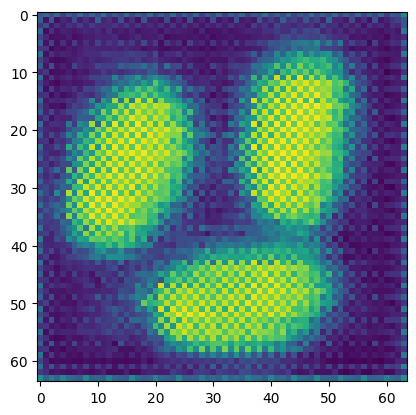

In [16]:
import matplotlib.pyplot as plt
plt.imshow(sample_img)

In [7]:
kloss_dict

NameError: name 'kloss_dict' is not defined

In [ ]:
from autoencodix.modeling._varix_architecture import VarixArchitecture
from autoencodix.modeling._imagevae_architecture import ImageVAEArchitecture
# class XModaleTrainer(GeneralTrainer):

for batch in trainloader:
    dt = batch.keys()


In [ ]:
import torch
from autoencodix.base._base_dataset import DataSetTypes

def _init_modality_training(self):
    model_map = {
        DataSetTypes.NUM: VarixArchitecture,
        DataSetTypes.IMG: ImageVAEArchitecture,
    }
    modality_training_helper = {mod_name: None for mod_name in trainset.datasets.keys()}
    for mod_name, ds in trainset.datasets.items():
        model_type = model_map.get(ds.mytype)
        if model_type is None:
            raise ValueError()
        model = model_type(config=img_config, input_dim=ds.get_input_dim())
        optimizer = torch.optim.AdamW(
            params=model.parameters(),
            lr=img_config.learning_rate,
            weight_decay=img_config.weight_decay,
        )
        modality_training_helper[mod_name] = {
            "model": model,
            "optim": optimizer,
            "mp": [],
            "losses": [],
        }


In [ ]:
from autoencodix.utils._losses import VarixLoss
vl = VarixLoss(config=img_config)
for k, v in batch.items():
    model = modality_training_helper[k]["model"]
    data = v["data"]
    print(data.shape)

    mp = model(data)
    losses = vl(model_output = mp, targets = data)
    break

In [ ]:
type(batch)

In [ ]:
losses

In [ ]:
mp

In [ ]:
jkkkmodels

In [ ]:
trainloader.dataset.datasets[]

In [ ]:
jds

In [ ]:
batch = next(xmodalix.fit())

In [ ]:
type(batch)

In [ ]:
print(batch.keys())
print(type(batch[list(batch.keys())[0]]))
print(batch[list(batch.keys())[0]].keys())

In [ ]:
len(batch["multi_bulk.RNA"]["metadata"])

In [ ]:
len(batch["multi_bulk.RNA"]["sample_ids"])

In [ ]:
import pandas as pd
import numpy as np

nacount = 0
for i, md in enumerate(batch["multi_bulk.RNA"]["metadata"]):
    if md is None:
        print("none for")
        print(batch["multi_bulk.RNA"]["sample_ids"][i])


In [ ]:
md = batch["multi_bulk.RNA"]["metadata"]
md

In [ ]:
import numpy as np

np.stack(md)

In [ ]:
batch["img.IMG"]["dtype"]

## Training Xmodal artefact

In [ ]:
fo

## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [ ]:
import autoencodix as acx
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

In [ ]:
imagix.predict()

In [ ]:
r = imagix.result
r.final_reconstruction
sample_img = r.final_reconstruction.data[0, :, :, :]
sample_img = sample_img.squeeze()

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sample_img.numpy())

### Old, maybe reuse code for getting stats, but seemd to work

In [ ]:
# Simple statistics tracking - just build the dict in your training loop

# Initialize stats dict once before training
stats = {}
for modality in trainset.datasets.keys():
    stats[modality] = {}
    for sample_id in trainset.datasets[modality].sample_ids:
        stats[modality][sample_id] = 0
print(stats)
# Training loop
epochs = 100

# Add this to your training loop
for epoch in range(100):  # Just test first 5 epochs
    batch_count = 0
    for batch_idx, batch in enumerate(dataloader):
        batch_count += 1

    print(f"Epoch {epoch}: {batch_count} batches processed")

    # Also check sampler length
    print(f"Sampler length: {len(sampler)}")
    print(f"Dataset length: {len(trainset)}")
    print(f"Paired samples: {len(trainset.paired_sample_ids)}")
    print(f"Unpaired samples: {len(trainset.unpaired_sample_ids)}")
    # # Reset stats for new epoch
    # for modality in stats:
    #     for sample_id in stats[modality]:
    #         stats[modality][sample_id] = 0

    for batch_idx, batch in enumerate(dataloader):
        # Update stats with current batch
        for modality, data in batch.items():
            if "sample_ids" in data:
                for sample_id in data["sample_ids"]:
                    if sample_id in stats[modality]:
                        stats[modality][sample_id] += 1

        # Your training code here
        # for modality, data in batch.items():
        #     if data["data"] is not None:
        #         outputs = models[modality](data["data"])

    # Print simple summary at end of epoch
    print("\nSampling Stats:")
    for modality in stats:
        counts = list(stats[modality].values())
        seen = sum(1 for c in counts if c > 0)
        total = len(counts)
        avg = sum(counts) / len(counts) if counts else 0
        print(f"  {modality}: {seen}/{total} samples seen, avg: {avg:.2f}")

    # Optional: Print unseen samples
    print("\nUnseen samples:")
    for modality in stats:
        unseen = [sid for sid, count in stats[modality].items() if count == 0]
        if unseen:
            print(
                f"  {modality}: {len(unseen)} unseen - {unseen[:5]}{'...' if len(unseen) > 5 else ''}"
            )

# Access raw stats anytime:
# stats = {
#     "img.IMG": {"T_98": 3, "T_138": 2, "T_183": 1, ...},
#     "multi_bulk.RNA": {"T_98": 4, "T_138": 3, "T_173": 2, ...},
#     ...
# }